In [1]:
import pickle
import numpy as np

def get_fire_stats(layer_feat_b):
    stats1 = []
    stats2 = []
    for nn in range(len(layer_feat_b)):
        stats1.append(np.mean(np.sum(layer_feat_b[nn], axis=2)))
        stats2.append(np.sum(np.sum(layer_feat_b[nn], axis=2)==0)/(layer_feat_b[nn].shape[0]*layer_feat_b[nn].shape[1]))
        
    return np.mean(stats1), np.mean(stats2)


def get_IOU(layer_feat_b1, layer_feat_b2):
    stats1 = []
    stats2 = []
    stats3 = []
    for nn in range(len(layer_feat_b1)):
        intr = np.sum(np.logical_and(layer_feat_b1[nn], layer_feat_b2[nn]))
        union = np.sum(np.logical_or(layer_feat_b1[nn], layer_feat_b2[nn]))
        stats1.append(intr/union)
        stats2.append(intr/np.sum(layer_feat_b1[nn]))
        stats3.append(intr/np.sum(layer_feat_b2[nn]))
        
    return(np.mean(stats1), np.mean(stats2), np.mean(stats3))


def get_detail(layer_feat_b1, layer_feat_b2):
    stats1 = []
    stats2 = []
    zero_cnt = 0
    single_cnt = 0
    for nn in range(len(layer_feat_b1)):
        rr, cc, vch = np.where(layer_feat_b1[nn] != layer_feat_b2[nn])
        for ri, ci in zip(rr, cc):
            stats1.append(np.sum(layer_feat_b1[nn][ri, ci]))
            stats2.append(np.sum(layer_feat_b2[nn][ri, ci]))
            if np.sum(layer_feat_b1[nn][ri, ci]) == 0:
                zero_cnt += 1
                
            if np.sum(layer_feat_b2[nn][ri, ci]) == 0:
                single_cnt += 1
            
                
    return(np.mean(stats1), np.mean(stats2), zero_cnt, single_cnt)

In [2]:
savefile = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/pool4FeatVC.pickle'
with open(savefile, 'rb') as fh:
    feat_set_ori, r_set_ori, feat_set_fake, r_set_fake = pickle.load(fh)
    
N = len(r_set_ori)
layer_feat_b_ori = [None for nn in range(N)]
layer_feat_b_fake = [None for nn in range(N)]
thrh4 = 0.46

stats1_ori=[]
stats2_ori=[]
stats1_fake=[]
stats2_fake=[]
for nn in range(N):
    layer_feat_b_ori[nn] = (r_set_ori[nn]<thrh4).astype(int)
    layer_feat_b_fake[nn] = (r_set_fake[nn]<thrh4).astype(int)

print(get_fire_stats(layer_feat_b_ori))
print(get_fire_stats(layer_feat_b_fake))  

print(get_IOU(layer_feat_b_ori,layer_feat_b_fake))
print(get_detail(layer_feat_b_ori,layer_feat_b_fake))
total_pixel = np.sum([np.prod(lfb.shape[0:2]) for lfb in layer_feat_b_ori])
total_diff_pixel = np.sum([np.sum(np.sum(layer_feat_b_ori[nn]!=layer_feat_b_fake[nn], axis=2)!=0) for nn in range(len(layer_feat_b_ori))])

(2.6807627184760814, 0.25347507908070288)
(2.112305417282013, 0.333511007705803)
(0.64275819143039392, 0.70089860467188692, 0.88415952217112426)
(5.1405611143904428, 2.6082069321202344, 24115, 208270)


In [16]:
import numpy as np
import pickle
import scipy.io as sio
import os

category='aeroplane'
dir_anno = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Annotations/{}_imagenet/'.format(category)
# file_list = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/car_test.txt'
file_list = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/aeroplane_mergelist_rand_test.txt'
with open(file_list, 'r') as fh:
    content = fh.readlines()
    
img_list = [x.strip().split() for x in content]
img_num = len(img_list)
print('total number of images: {0}'.format(img_num))

view_point = np.zeros(img_num)
for nn in range(img_num):
    
    file_anno = os.path.join(dir_anno, '{0}.mat'.format(img_list[nn][0]))
    assert(os.path.isfile(file_anno))
    mat_contents = sio.loadmat(file_anno)
    record = mat_contents['record']
    width_im,height_im = record['imgsize'][0][0][0][0:2]
    objects = record['objects']
    
    view_point[nn] = objects[0,0]['viewpoint'][0,int(img_list[nn][1])-1]['azimuth_coarse'][0,0][0,0]
    
print(view_point[0:10])

total number of images: 824
[ 310.  275.  280.  310.  310.  305.  345.  270.  315.  265.]


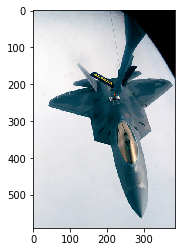

"\nplt.imshow(matcontent['im_ori'])\nplt.show()\nplt.imshow(matcontent['im_fool'].astype('uint8'))\nplt.show()\n"

In [17]:
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import cv2

nn = 534
# dir_mat = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/adv_mat_file/'
img_dir = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Images/aeroplane_imagenet/'
# file_mat = os.path.join(dir_mat, '{0}.mat'.format(img_list[nn][0]))
file_img = os.path.join(img_dir, '{0}.JPEG'.format(img_list[nn][0]))
assert(os.path.isfile(file_mat))
# matcontent = sio.loadmat(file_mat)
img = cv2.imread(file_img)
plt.imshow(img[:,:,[2,1,0]])
plt.show()
'''
plt.imshow(matcontent['im_ori'])
plt.show()
plt.imshow(matcontent['im_fool'].astype('uint8'))
plt.show()
'''

In [2]:
file_path = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/'
savename = file_path + 'simmat_carplane_vMFMM30_mthrh047_allVC.pickle'
with open(savename, 'rb') as fh:
    mat_dis1, mat_dis2, mat_dis1_fake, mat_dis2_fake = pickle.load(fh)

350.0
345.0 155.0 270.0 345.0 350.0 .
225.0
200.0 245.0 275.0 235.0 345.0 .
85.0
65.0 80.0 90.0 105.0 85.0 .
50.0
90.0 70.0 105.0 95.0 255.0 .
45.0
65.0 50.0 75.0 325.0 50.0 .
345.0
290.0 350.0 340.0 295.0 330.0 .
270.0
275.0 265.0 265.0 285.0 285.0 .
40.0
60.0 280.0 345.0 225.0 315.0 .
85.0
105.0 55.0 60.0 95.0 90.0 .
230.0
230.0 230.0 290.0 315.0 230.0 .


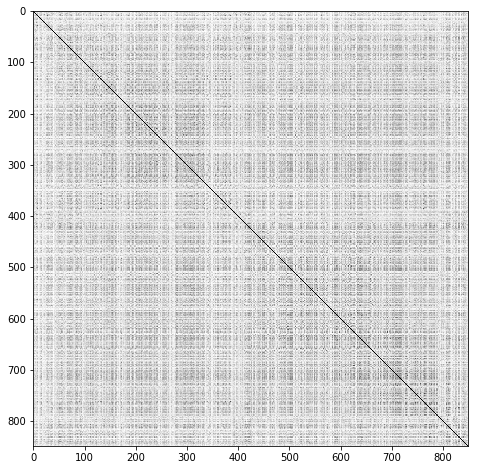

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

mat_dis = mat_dis1[1000:][:,1000:]
N = mat_dis.shape[0]
mat_full = mat_dis + mat_dis.T - np.ones((N,N))
np.fill_diagonal(mat_full, 0)

idx_s = np.argsort(view_point)
gridix = np.ix_(idx_s,idx_s)
plt.imshow(mat_full[gridix])

for rr in np.random.randint(N,size=10):
    ref = rr
    print(view_point[ref])
    dis_rst = mat_full[rr]
    min_idx = np.argsort(dis_rst)
    for tt in range(1,6):
        match = min_idx[tt]
        print(view_point[match], end=' ')
        
    print('.')

340.0
335.0 325.0 340.0 335.0 330.0 .
340.0
340.0 340.0 340.0 340.0 340.0 .
5.0
0.0 5.0 10.0 10.0 10.0 .
90.0
90.0 90.0 90.0 105.0 90.0 .
310.0
305.0 315.0 290.0 320.0 315.0 .
10.0
20.0 20.0 20.0 25.0 25.0 .
5.0
10.0 5.0 0.0 20.0 10.0 .
55.0
55.0 75.0 55.0 60.0 60.0 .
200.0
210.0 190.0 200.0 195.0 190.0 .
25.0
20.0 55.0 30.0 35.0 30.0 .


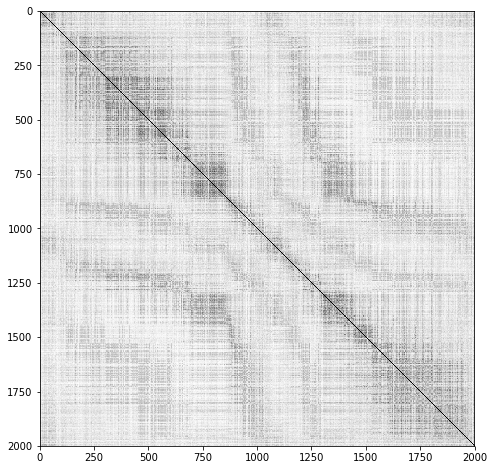

In [15]:
mat_dis = mat_dis1_fake
mat_full = mat_dis + mat_dis.T - np.ones((N,N))
np.fill_diagonal(mat_full, 0)

idx_s = np.argsort(view_point)
gridix = np.ix_(idx_s,idx_s)
plt.imshow(mat_full[gridix])

for rr in np.random.randint(img_num,size=10):
    ref = rr
    print(view_point[ref])
    dis_rst = mat_full[rr]
    min_idx = np.argsort(dis_rst)
    for tt in range(1,6):
        match = min_idx[tt]
        print(view_point[match], end=' ')
        
    print('.')

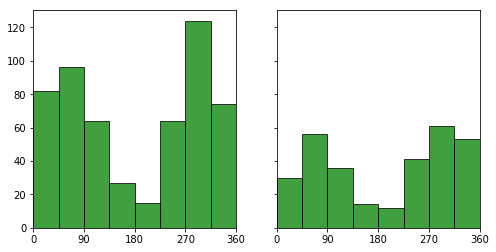

0.214946661832 0.106877936169
0.150702540099 0.0941565414529


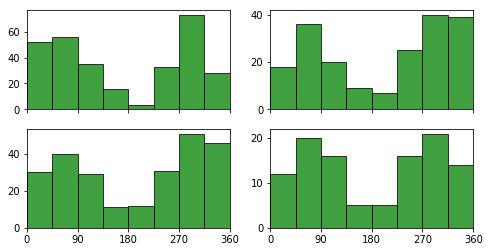

In [4]:
from sklearn.cluster import SpectralClustering
W_mat = 1. - mat_full
K = 2
cls_solver = SpectralClustering(n_clusters=K,affinity='precomputed', random_state=666)
lb = cls_solver.fit_predict(W_mat)

f, axes = plt.subplots(1,K, sharex=True, sharey=True, figsize=(8,4))
axes[0].set_xlim([0,360])
axes[0].set_xticks([0,90,180,270,360])

for k in range(K):
    axes[k].hist(np.array(view_point)[lb==k], bins=8, range=[0,360], facecolor='green', alpha=0.75,edgecolor='k')

plt.show()

idx2 = []
W_mat2 = []
lb2 = []
for k in range(K):
    idx2.append(np.where(lb==k)[0])
    W_mat2.append(W_mat[np.ix_(idx2[k],idx2[k])])
    print(np.mean(W_mat2[k]), np.std(W_mat2[k]))
    
    cls_solver = SpectralClustering(n_clusters=2,affinity='precomputed', random_state=999)
    lb2.append(cls_solver.fit_predict(W_mat2[k]))
    
K2=2
f, axes = plt.subplots(2,K, sharex=True, sharey=False, figsize=(8,4))
axes[0][0].set_xlim([0,360])
axes[0][0].set_xticks([0,90,180,270,360])
for k in range(K2*K):
    a = k//2
    b = k%2
    axes[b][a].hist(np.array(view_point)[idx2[a]][lb2[a]==b], bins=8, range=[0,360], facecolor='green', alpha=0.75, edgecolor='k')

plt.show()

In [1]:
import math 
def comptScores(inp, obj_weight, logZ):
    hi,wi,ci = inp.shape
    ho,wo,co = obj_weight.shape
    assert(ci == co)
    if hi > ho:
        diff1 = math.floor((hi-ho)/2)
        inp = inp[diff1: diff1+ho, :, :]
    else:
        diff1 = math.floor((ho-hi)/2)
        diff2 = ho-hi-diff1
        inp = np.pad(inp, ((diff1, diff2),(0,0),(0,0)), 'constant', constant_values=0)
        
    assert(inp.shape[0] == ho)
    
    if wi > wo:
        diff1 = math.floor((wi-wo)/2)
        inp = inp[:, diff1: diff1+wo, :]
    else:
        diff1 = math.floor((wo-wi)/2)
        diff2 = wo-wi-diff1
        inp = np.pad(inp, ((0,0),(diff1, diff2),(0,0)), 'constant', constant_values=0)
        
    assert(inp.shape[1] == wo)
    
    term1 = inp*obj_weight
    score = np.sum(term1) - logZ
    return score

def comptScoresM(inp, all_weights, all_logZs):
    scores_i = []
    for kk in range(len(all_weights)):
        scores_i.append(comptScores(inp, all_weights[kk].T, all_logZs[kk]))
        
    return np.max(scores_i)
        

def predictLabel(inp, all_weights1, all_logZs1, all_weights2, all_logZs2):
    score1 = comptScoresM(inp, all_weights1, all_logZs1)
    score2 = comptScoresM(inp, all_weights2, all_logZs2)
    
    return int(score2>score1), score1-score2

In [13]:
import pickle
import numpy as np
from scipy.spatial.distance import cdist

category1='car'
category2='aeroplane'
K = 4
magic_thh = 0.47
file_path = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/'
# feat_fname = file_path + 'pool4FeatVC_car.pickle'
feat_fname = file_path + 'pool4FeatVC_aeroplane_test.pickle'
dict_file='/export/home/qliu24/qing_voting_139/qing_voting_py/data/dictionary_PASCAL3D+_all_VGG16_pool4_K200_vMFMM30.pickle'
# dict_file='/export/home/qliu24/qing_voting_139/qing_voting_py/data/dictionary_PASCAL3D+_car_VGG16_pool4_K200_vMFMM30.pickle'
model_file1 = file_path + 'mix_model/{}_K{}_notrain.pickle'.format(category1, K)
model_file2 = file_path + 'mix_model/{}_K{}_notrain.pickle'.format(category2, K)

with open(feat_fname, 'rb') as fh:
    layer_feature = pickle.load(fh)
    
# layer_feature = layer_feature[1000:]

with open(dict_file, 'rb') as fh:
    _, centers, _ = pickle.load(fh)
     
with open(model_file1, 'rb') as fh:
    all_weights1, _ = pickle.load(fh)
    
assert(len(all_weights1) == K)
all_logZs1 = []
for kk in range(K):
    all_logZs1.append(np.sum(np.log(1+np.exp(all_weights1))))
    
with open(model_file2, 'rb') as fh:
    all_weights2, _ = pickle.load(fh)
    
assert(len(all_weights2) == K)
all_logZs2 = []
for kk in range(K):
    all_logZs2.append(np.sum(np.log(1+np.exp(all_weights2))))

N = len(layer_feature)
r_set = [None for nn in range(N)]
for nn in range(N):
    iheight,iwidth = layer_feature[nn].shape[0:2]
    lff = layer_feature[nn].reshape(-1, 512)
    lff_norm = lff/np.sqrt(np.sum(lff**2, 1)).reshape(-1,1)
    r_set[nn] = cdist(lff_norm, centers, 'cosine').reshape(iheight,iwidth,-1)
    
layer_feature_b = [None for nn in range(N)]
for nn in range(N):
    layer_feature_b[nn] = (r_set[nn]<magic_thh).astype(int)

In [14]:
labels = []
scores = []
for nn in range(N):
    if nn%50==0:
        print('sample {}'.format(nn))
        
    lfb = layer_feature_b[nn]
    rst = predictLabel(lfb, all_weights1, all_logZs1, all_weights2, all_logZs2)
    labels.append(rst[0])
    scores.append(rst[1])
    if rst[0]==0:
        print(nn)
    
print(np.sum(labels)/N)
print(np.mean(scores),np.std(scores))

sample 0
sample 50
sample 100
sample 150
sample 200
sample 250
sample 300
sample 350
sample 400
sample 450
sample 500
534
sample 550
sample 600
sample 650
sample 700
sample 750
sample 800
0.998786407767
-1488.76351843 890.897531797


In [ ]:
0.002
1389.13993194 668.742870714
0.002
1178.56989619 569.693156694

In [6]:
(1389.13993194-1178.56989619)/1389.13993194

0.15158302695677958